In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import glob
import json
import os
from pprint import pprint

In [11]:
results_base = "experiments/results/"
results_dir = "query_expansions"
path = results_base + results_dir

# Get every .json file in every subdir
json_files = glob.glob(os.path.join(path, "**/*.json"), recursive=True)
pprint(json_files)

['experiments/results/baselines/basic_bge_contributions_identity_normTrue_ip_n14735_20250819_142020/results_basic_bge_contributions_identity_normTrue_ip_n14735_20250819_142020.json',
 'experiments/results/baselines/basic_specter_chunks_identity_normFalse_ip_n14735_20250819_130621/results_basic_specter_chunks_identity_normFalse_ip_n14735_20250819_130621.json',
 'experiments/results/baselines/basic_bge_chunks_identity_normTrue_ip_n14735_20250819_125001/results_basic_bge_chunks_identity_normTrue_ip_n14735_20250819_125001.json',
 'experiments/results/baselines/basic_astrobert_chunks_identity_normFalse_ip_n14735_20250819_125806/results_basic_astrobert_chunks_identity_normFalse_ip_n14735_20250819_125806.json',
 'experiments/results/baselines/basic_specter_contributions_identity_normFalse_ip_n14735_20250819_142457/results_basic_specter_contributions_identity_normFalse_ip_n14735_20250819_142457.json',
 'experiments/results/baselines/basic_astrobert_contributions_identity_normFalse_ip_n14735_20

In [12]:
def filename_to_label(filename):
    
    pieces = filename.split("_")
    model = pieces[1]
    document_rep = pieces[2]
    query_expansion = "" if pieces[3] == "identity" else pieces[3]
    norm = "normed" if "normTrue" in filename else ""
    # Filter out empty strings before joining
    parts = [model, document_rep, query_expansion, norm]
    return "+".join([part for part in parts if part])


filename_to_label(json_files[0])

'bge+contributions+normed'

In [13]:
# Build data dict
data = dict()
for file in json_files:
    experiment_results = json.load(open(file))
    hitrates = experiment_results["average_hitrate_at_k"]
    label = filename_to_label(file)
    data[label] = hitrates

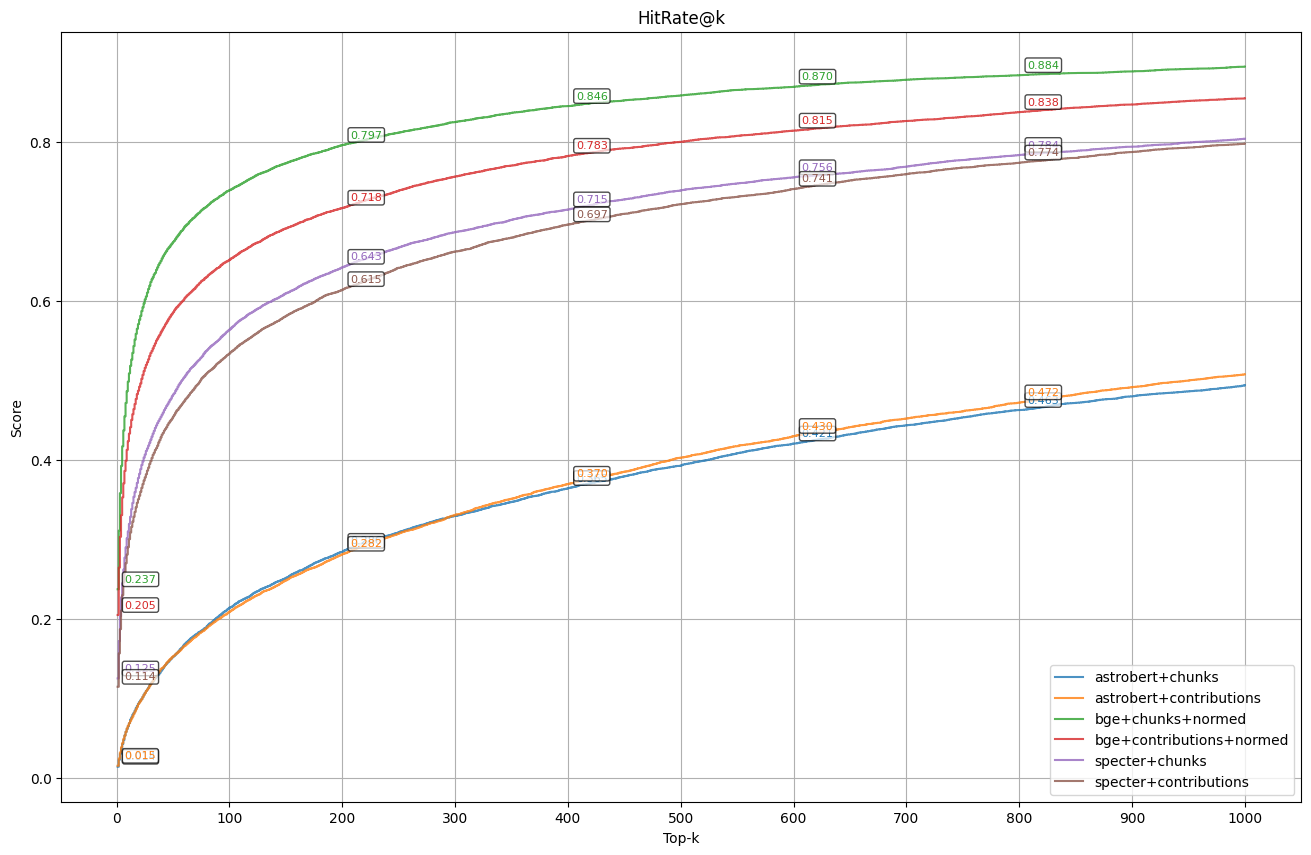

In [16]:
k_values = [k for k in range(1, 1001)]

# Make a plot of the average hit rates (y-axis) and IoU (Jaccard) vs. top-k (x-axis)
plt.figure(figsize=(16, 10))
lines = []
for label, hitrates in sorted(data.items()):
    (line,) = plt.plot(k_values, hitrates, drawstyle="steps-post", linestyle="-", lw=1.5, alpha=0.8, label=label)
    lines.append((line, label, hitrates))

plt.xlabel("Top-k")
plt.ylabel("Score")
plt.title("HitRate@k")
plt.legend()
plt.grid()

# Set x-ticks every 100
plt.gca().xaxis.set_major_locator(MultipleLocator(100))
plt.savefig(f"{results_dir}_k1000.png")
plt.show()
plt.close()